In [151]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [153]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

In [154]:
root='./data'
download=True
batch_size=int(2**11)
shuffle=True
include_last_if_uneven=True
binarise_thesh=0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=True,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)
test_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=False,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)

In [155]:
for batch_id, datum in enumerate(tqdm.tqdm(test_MNIST_loader)):
    if batch_id == 0:
        print(batch_id)
        print(torch.max(datum.input))
        print(torch.min(datum.input))
        print(datum.target)

 40%|████      | 2/5 [00:00<00:00, 17.46it/s]

0
tensor(1, dtype=torch.int32)
tensor(-1, dtype=torch.int32)
tensor([[-1,  1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1,  1],
        [ 1, -1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1,  1]], dtype=torch.int32)


100%|██████████| 5/5 [00:00<00:00, 19.79it/s]


In [156]:
len(test_MNIST_loader), len(train_MNIST_loader)

(5, 30)

In [157]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [158]:
backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
#backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)
#backward_func = bnn.functions.backward.LayerQuantileSymmetricTernarise(prop_zero=0.5)

In [159]:
INPUT_DIM = bnn.data.MNISTDataLoader.input_size
OUTPUT_DIM = bnn.data.MNISTDataLoader.output_size

In [160]:
hidden = 1024
vote_bits = 128
dims = [INPUT_DIM, hidden, hidden, hidden, OUTPUT_DIM * vote_bits]

n_layers = len(dims) - 1

forward_funcs = [forward_func] * (n_layers - 1) + [bnn.functions.forward.BitCountMax(out_dims=OUTPUT_DIM, extra_dims=vote_bits)]
backward_funcs = [backward_func] * (n_layers - 1) + [bnn.functions.backward.BackwardBitCountMax(extra_dims=vote_bits)]

In [161]:
TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_funcs,
    backward_func=backward_funcs,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [162]:
TBNN.to(device)
train_MNIST_loader.to(device)
test_MNIST_loader.to(device)

In [163]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [164]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=1e-3)
#BernOpt = bnn.optimizer.DeterministicSGD(TBNN.parameters(), lr=1e-3)

In [165]:
losses = []
test_accs = []
test_accs_epochs = []

In [166]:
train_epochs = 40
num_logs = 20
epoch_log_rate = train_epochs // num_logs

In [167]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_onehot = TBNN.forward(batch.input)
    output_argmax = torch.argmax(output_onehot, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 20.24it/s]

accuracy: 0.10130000114440918


In [168]:
output_onehot.shape

torch.Size([1808, 10])

In [169]:
zero_loss_count = 0
zero_loss_count_for_early_stop = 10
for epoch in tqdm.trange(train_epochs):
    epoch_loss = 0
    prop_flipped = 0
    for batch_id, batch in enumerate(train_MNIST_loader):
        # forward pass and loss
        output = TBNN.forward(batch.input)
        loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        prop_flipped += BernOpt.step()

        # sum loss
        epoch_loss += loss

    # save loss
    losses.append(epoch_loss.cpu())

    if epoch_loss == 0:
        zero_loss_count += 1
    else:
        zero_loss_count = 0

    early_exit = zero_loss_count >= zero_loss_count_for_early_stop

    if early_exit or (epoch % epoch_log_rate) == 0:
        mean_prop_flipped = prop_flipped / (1 + batch_id)
        print(f'epoch: {epoch}\tloss: {loss}\tmean_prop_flipped: {mean_prop_flipped}')

        # test
        test_num_correct = 0
        test_total = test_MNIST_loader._datapoints
        for batch_id, batch in enumerate(test_MNIST_loader):
            # forward pass and loss
            output = TBNN.forward(batch.input)

            output_argmax = torch.argmax(output, dim=-1)
            target_argmax = torch.argmax(batch.target, dim=-1)

            test_num_correct += torch.sum(target_argmax == output_argmax)

        test_acc = test_num_correct / test_total
        test_accs.append(test_acc.cpu())
        test_accs_epochs.append(epoch)
        print(f"test accuracy: {test_acc}")

    if early_exit:
        break

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0	loss: 2.0657894611358643	mean_prop_flipped: 0.00010668091999832541


  2%|▎         | 1/40 [00:02<01:20,  2.08s/it]

test accuracy: 0.49619999527931213


  5%|▌         | 2/40 [00:03<01:06,  1.76s/it]

epoch: 2	loss: 1.4736841917037964	mean_prop_flipped: 5.288130705594085e-05


  8%|▊         | 3/40 [00:05<01:10,  1.90s/it]

test accuracy: 0.6553999781608582


 10%|█         | 4/40 [00:07<01:05,  1.83s/it]

epoch: 4	loss: 1.105263113975525	mean_prop_flipped: 4.882811481365934e-05


 12%|█▎        | 5/40 [00:09<01:05,  1.88s/it]

test accuracy: 0.7069999575614929


 15%|█▌        | 6/40 [00:11<01:02,  1.83s/it]

epoch: 6	loss: 1.1513158082962036	mean_prop_flipped: 4.495702523854561e-05


 18%|█▊        | 7/40 [00:12<01:00,  1.82s/it]

test accuracy: 0.7301999926567078


 20%|██        | 8/40 [00:14<00:55,  1.75s/it]

epoch: 8	loss: 1.138157844543457	mean_prop_flipped: 4.078510028193705e-05


 22%|██▎       | 9/40 [00:16<00:54,  1.76s/it]

test accuracy: 0.7471999526023865


 25%|██▌       | 10/40 [00:17<00:51,  1.71s/it]

epoch: 10	loss: 1.0855263471603394	mean_prop_flipped: 4.118092329008505e-05


 28%|██▊       | 11/40 [00:19<00:51,  1.79s/it]

test accuracy: 0.7619999647140503


 30%|███       | 12/40 [00:21<00:48,  1.74s/it]

epoch: 12	loss: 0.8815789818763733	mean_prop_flipped: 4.2281295463908464e-05


 32%|███▎      | 13/40 [00:23<00:49,  1.82s/it]

test accuracy: 0.7655999660491943


 35%|███▌      | 14/40 [00:25<00:52,  2.02s/it]

epoch: 14	loss: 0.9802631735801697	mean_prop_flipped: 4.160840035183355e-05


 38%|███▊      | 15/40 [00:28<00:51,  2.06s/it]

test accuracy: 0.769599974155426


 40%|████      | 16/40 [00:30<00:49,  2.05s/it]

epoch: 16	loss: 0.9013158082962036	mean_prop_flipped: 4.028636612929404e-05


 42%|████▎     | 17/40 [00:32<00:47,  2.05s/it]

test accuracy: 0.769599974155426


 45%|████▌     | 18/40 [00:33<00:42,  1.95s/it]

epoch: 18	loss: 0.9342105388641357	mean_prop_flipped: 4.371415343484841e-05


 48%|████▊     | 19/40 [00:36<00:45,  2.15s/it]

test accuracy: 0.7684999704360962


 50%|█████     | 20/40 [00:38<00:40,  2.03s/it]

epoch: 20	loss: 0.7631579041481018	mean_prop_flipped: 4.0508028178010136e-05


 52%|█████▎    | 21/40 [00:40<00:38,  2.02s/it]

test accuracy: 0.777899980545044


 55%|█████▌    | 22/40 [00:42<00:34,  1.93s/it]

epoch: 22	loss: 0.9342105388641357	mean_prop_flipped: 3.9684724470134825e-05


 57%|█████▊    | 23/40 [00:43<00:32,  1.94s/it]

test accuracy: 0.7734000086784363


 60%|██████    | 24/40 [00:45<00:29,  1.87s/it]

epoch: 24	loss: 0.9342105388641357	mean_prop_flipped: 4.126799831283279e-05


 62%|██████▎   | 25/40 [00:47<00:29,  1.98s/it]

test accuracy: 0.7811999917030334


 65%|██████▌   | 26/40 [00:49<00:26,  1.92s/it]

epoch: 26	loss: 0.9736841917037964	mean_prop_flipped: 4.3001688027288765e-05


 68%|██████▊   | 27/40 [00:51<00:25,  1.93s/it]

test accuracy: 0.7798999547958374


 70%|███████   | 28/40 [00:53<00:22,  1.86s/it]

epoch: 28	loss: 0.9013158082962036	mean_prop_flipped: 4.110966983716935e-05


 72%|███████▎  | 29/40 [00:55<00:20,  1.87s/it]

test accuracy: 0.7831000089645386


 75%|███████▌  | 30/40 [00:56<00:18,  1.82s/it]

epoch: 30	loss: 0.8289473652839661	mean_prop_flipped: 4.3476666178321466e-05


 78%|███████▊  | 31/40 [00:58<00:16,  1.85s/it]

test accuracy: 0.7872999906539917


 80%|████████  | 32/40 [01:00<00:15,  1.88s/it]

epoch: 32	loss: 0.75	mean_prop_flipped: 4.149757296545431e-05


 82%|████████▎ | 33/40 [01:02<00:13,  1.98s/it]

test accuracy: 0.7833999991416931


 85%|████████▌ | 34/40 [01:04<00:11,  1.92s/it]

epoch: 34	loss: 0.9013158082962036	mean_prop_flipped: 4.120466473978013e-05


 88%|████████▊ | 35/40 [01:06<00:09,  1.94s/it]

test accuracy: 0.7858999967575073


 90%|█████████ | 36/40 [01:08<00:07,  1.91s/it]

epoch: 36	loss: 0.8552631735801697	mean_prop_flipped: 4.1814233554759994e-05


 92%|█████████▎| 37/40 [01:10<00:05,  1.97s/it]

test accuracy: 0.7836999893188477


 95%|█████████▌| 38/40 [01:12<00:03,  1.93s/it]

epoch: 38	loss: 0.9407894611358643	mean_prop_flipped: 4.41574738943018e-05


 98%|█████████▊| 39/40 [01:14<00:01,  1.95s/it]

test accuracy: 0.781499981880188


100%|██████████| 40/40 [01:16<00:00,  1.90s/it]


In [170]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_onehot = TBNN.forward(batch.input)
    output_argmax = torch.argmax(output_onehot, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 10.36it/s]

accuracy: 0.776699960231781


In [171]:
input_ims = batch.input.cpu().reshape(-1, 28, 28)
input_class = target_argmax.cpu()
output_class = output_argmax.cpu()

input_class.shape

torch.Size([1808])

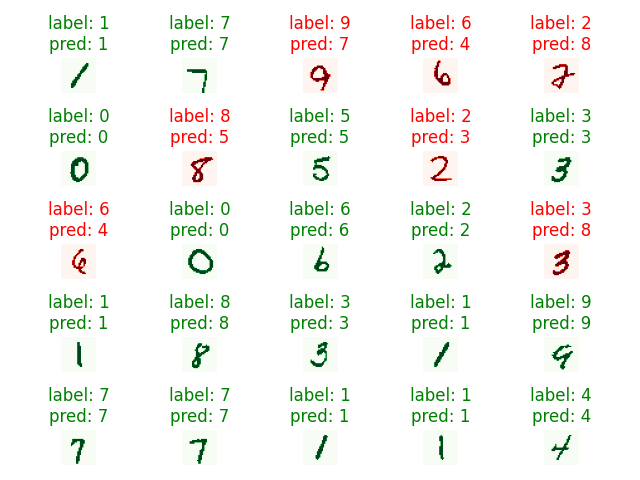

In [172]:
FIG_NAME = "preds"
plt.close(FIG_NAME)

num_plots = 25
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

for ax, in_im, in_cls, out_cls in zip(axs, input_ims, input_class, output_class):
    if in_cls == out_cls:
        c = "green"
        cmap = 'Greens'
    else:
        c = "red"
        cmap = 'Reds'
    ax.imshow(in_im, cmap=cmap)
    ax.set_title(f'label: {in_cls}\npred: {out_cls}', color=c)
    ax.axis('off')

fig.tight_layout()

plt.show()

In [185]:
k = 3
ins = torch.topk(output_onehot, k=k, dim=-1).indices
out = torch.zeros_like(output_argmax, dtype=bool)
for i in range(k):
    out |= ins[..., i] == target_argmax

torch.sum(out) / len(out)

tensor(0.8014, device='cuda:0')

In [186]:
import bnn.metrics

ds: list[bnn.random.DISCRETE_DIST | None] = []
for n, p in TBNN.named_parameters():
    if "W" in n:
        d = bnn.metrics.distribution(p.cpu())
        ds.append(d)

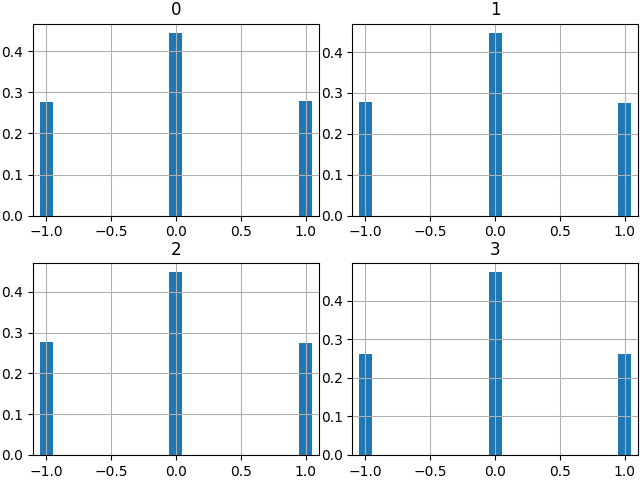

In [187]:
FIG_NAME = "dist"
plt.close(FIG_NAME)

num_plots = len(ds)
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
width=0.1
for i, (ax, d) in enumerate(zip(axs, ds + [None]*len(axs))):
    if d is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(0, 1), '-', color="red")
        ax.axis("off")

    else:
        ax.set_title(i)
        vals = [pair.value for pair in d]
        probs = [pair.probability for pair in d]

        if len(vals) > 3:
            ax.plot(vals, probs, 'o-')
        else:
            ax.bar(vals, probs, width=width)

        min_x = min(min_x, min(vals))
        max_x = max(max_x, max(vals))

for ax in axs:
    ax.set_xlim(min_x-width, max_x+width)
    ax.grid()

fig.tight_layout(pad=0.1)
plt.show()

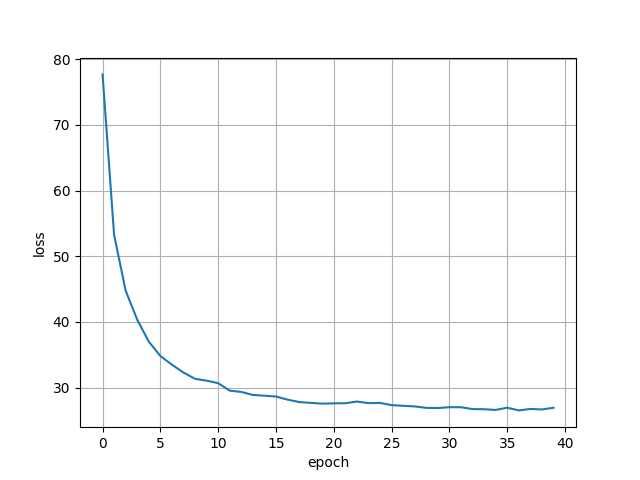

In [188]:
NAME = 'loss_curve'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

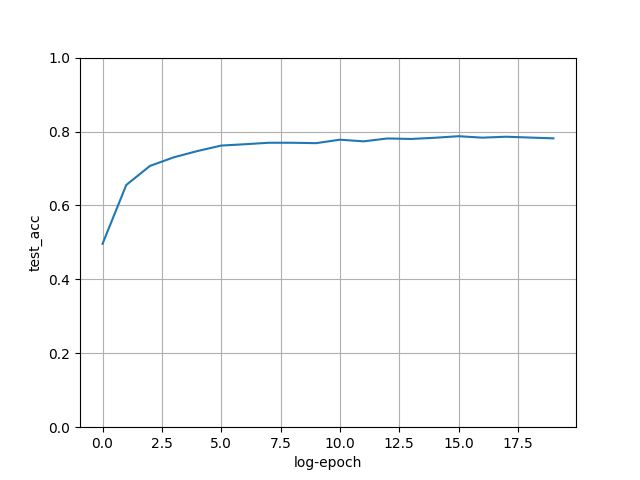

In [189]:
NAME = 'test_accs'
plt.close(NAME)
plt.figure(NAME)

plt.plot(test_accs)
plt.ylim(0, 1)
plt.xlabel('log-epoch')
plt.ylabel('test_acc')
plt.grid()

plt.show()

In [190]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[-1,  0,  0,  ..., -1,  0,  0],
        [ 0,  0,  0,  ...,  1, -1,  1],
        [ 1, -1, -1,  ...,  1,  1,  0],
        ...,
        [ 1,  0,  0,  ...,  1,  1, -1],
        [-1,  0,  0,  ..., -1, -1, -1],
        [-1,  0,  0,  ..., -1,  1,  0]], device='cuda:0', dtype=torch.int32) 
 None
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[-1,  0,  0,  ...,  0,  0,  0],
        [-1, -1,  0,  ...,  0,  1,  1],
        [ 1,  0,  0,  ..., -1,  0,  0],
        ...,
        [-1,  0,  1,  ..., -1, -1,  0],
        [ 0, -1,  0,  ...,  1, -1,  1],
        [ 1, -1, -1,  ..., -1,  0,  1]], device='cuda:0', dtype=torch.int32) 
 None
layers.TernBinLayer2.W 
 Parameter containing:
tensor([[-1,  0,  0,  ...,  1,  1, -1],
        [ 0, -1,  0,  ...,  1,  0, -1],
        [ 1,  1, -1,  ...,  0, -1, -1],
        ...,
        [-1,  0,  1,  ...,  0,  1, -1],
        [-1, -1,  0,  ...,  0,  0, -1],
        [ 0, -1,  0,  ...,  0, -1,  1]], device='cud

In [191]:
assert bnn.network.network_params_al_ternary(TBNN)